# Experiment with Different Feature Sets in Audio Mosaicing

In this notebook, we will reconstruct a target audio file by replacing its frames with similar frames selected from our source collection. We will experiment with different feature sets for matching:
- **Experiment A:** Using only MFCC coefficients (mfcc_0 to mfcc_12).
- **Experiment B:** Using a combination of MFCC coefficients plus loudness.

This will help us understand how the choice of features impacts the quality and character of the reconstructed audio.


## Environment Setup and Data Loading 

This cell loads the analyzed data for both source and target files from CSV files. We also import our audio mosaicing helper function for loading segments and performing nearest-neighbor searches.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import random
import sys
sys.path.append(os.path.abspath(".."))

# Import Essentia functions for audio I/O
import essentia.standard as estd

# Import our mosaicing functions from our module
from src.mosaicing import get_audio_file_segment, find_similar_frames

# Define paths to our analysis DataFrames (adjust these paths as needed)
SOURCE_ANALYSIS_FILE = '../data/metadata/source_analysis.csv'
TARGET_ANALYSIS_FILE = '../data/metadata/target_analysis.csv'
DATASET_FILE = '../data/metadata/fonts_collection.csv'  # Source metadata for reference

# Load DataFrames
df_source = pd.read_csv(SOURCE_ANALYSIS_FILE)
df_target = pd.read_csv(TARGET_ANALYSIS_FILE)
df_dataset = pd.read_csv(DATASET_FILE)

print(f"Source analysis frames: {len(df_source)}")
print(f"Target analysis frames: {len(df_target)}")


Source analysis frames: 3384
Target analysis frames: 241


## Define a Custom Frame Selection Function with Flexible Feature Sets

This function is similar to our module’s frame selection, but now it accepts a custom list of features. In our experiments we will try:

Feature set A: ['mfcc_0', 'mfcc_1', ..., 'mfcc_12']

Feature set B: ['loudness'] + ['mfcc_0', 'mfcc_1', ..., 'mfcc_12']

In [3]:
def choose_frame_with_features(target_frame, df_source_frames, similarity_features):
    """
    Select one source frame to replace a target frame using a custom set of similarity features.
    
    Parameters:
      - target_frame: A row (Series) from the target analysis DataFrame.
      - df_source_frames: The source analysis DataFrame.
      - similarity_features: A list of feature names to use for similarity matching.
    
    Returns:
      - A row (Series) from df_source_frames representing the chosen source frame.
    """
    n_neighbors = 10
    # Extract feature vector from the target frame
    query_vector = target_frame[similarity_features].values.reshape(1, -1)
    
    # Use NearestNeighbors from scikit-learn (same as our module function)
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(df_source_frames[similarity_features].values)
    distances, indices = nbrs.kneighbors(query_vector)
    
    # For variation, randomly choose one among the top similar frames
    similar_frames = [df_source_frames.iloc[k] for k in indices[0]]
    chosen_frame = random.choice(similar_frames)
    return chosen_frame


## Reconstruct Target Audio Using a Specified Feature Set 

In [4]:
def reconstruct_target(target_df, df_source, similarity_features):
    """
    Reconstruct the target audio by replacing each frame with a similar frame
    from the source analysis DataFrame, based on the given similarity features.
    
    Parameters:
      - target_df: DataFrame containing target audio frame analyses.
      - df_source: DataFrame containing source audio frame analyses.
      - similarity_features: List of features to use for similarity matching.
    
    Returns:
      - generated_audio: A numpy array containing the reconstructed audio.
      - used_ids: A list of source Freesound IDs used in the reconstruction.
    """
    # Load target audio from the first frame entry (assuming all frames belong to the same file)
    target_sound_path = target_df.iloc[0]['path']
    target_audio = estd.MonoLoader(filename=target_sound_path)()
    total_length = len(target_audio)
    
    # Initialize output array for reconstructed audio
    generated_audio = np.zeros(total_length)
    used_ids = []
    
    # Process each target frame
    for idx, target_frame in target_df.iterrows():
        # Select a similar source frame using the provided feature set
        chosen_frame = choose_frame_with_features(target_frame, df_source, similarity_features)
        used_ids.append(chosen_frame['freesound_id'])
        
        # Determine the length of the target frame
        n_samples = target_frame['end_sample'] - target_frame['start_sample']
        # Extract corresponding audio segment from the chosen source frame
        source_audio_segment = get_audio_file_segment(chosen_frame['path'], chosen_frame['start_sample'], n_samples)
        # Place the source audio segment into the reconstructed audio array
        start_idx = target_frame['start_sample']
        generated_audio[start_idx:start_idx+len(source_audio_segment)] = source_audio_segment
    
    return generated_audio, used_ids

# Define two different feature sets for experimentation:
mfcc_features = [f'mfcc_{i}' for i in range(13)]
mfcc_plus_loudness = ['loudness'] + mfcc_features

# Choose one feature set to test (you can later loop over both)
print("Reconstructing using MFCC features only...")
reconstructed_audio_A, used_ids_A = reconstruct_target(df_target, df_source, mfcc_features)
print("Reconstructing using MFCC + Loudness features...")
reconstructed_audio_B, used_ids_B = reconstruct_target(df_target, df_source, mfcc_plus_loudness)


Reconstructing using MFCC features only...
Reconstructing using MFCC + Loudness features...


## Save and Compare the Reconstructed Audio

This cell writes both reconstructed audio outputs to WAV files, plots their waveforms, and creates audio players so you can listen to the differences. Comparing these outputs will help you determine how the inclusion of additional features (like loudness) affects the result.

[   INFO   ] Warning: essentia can currently only accept numpy arrays of dtype "single". "audio" dtype is double. Precision will be automatically truncated into "single".
[wav @ 0x2e6b4ec0] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x2e6b4ec0] Encoder did not produce proper pts, making some up.
[   INFO   ] Warning: essentia can currently only accept numpy arrays of dtype "single". "audio" dtype is double. Precision will be automatically truncated into "single".
[wav @ 0x2e6b4ec0] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.


Reconstructed audio (MFCC only) saved as: ../data/raw/464477_1648170-hq.ogg_reconstructed_A.wav
Reconstructed audio (MFCC + Loudness) saved as: ../data/raw/464477_1648170-hq.ogg_reconstructed_B.wav


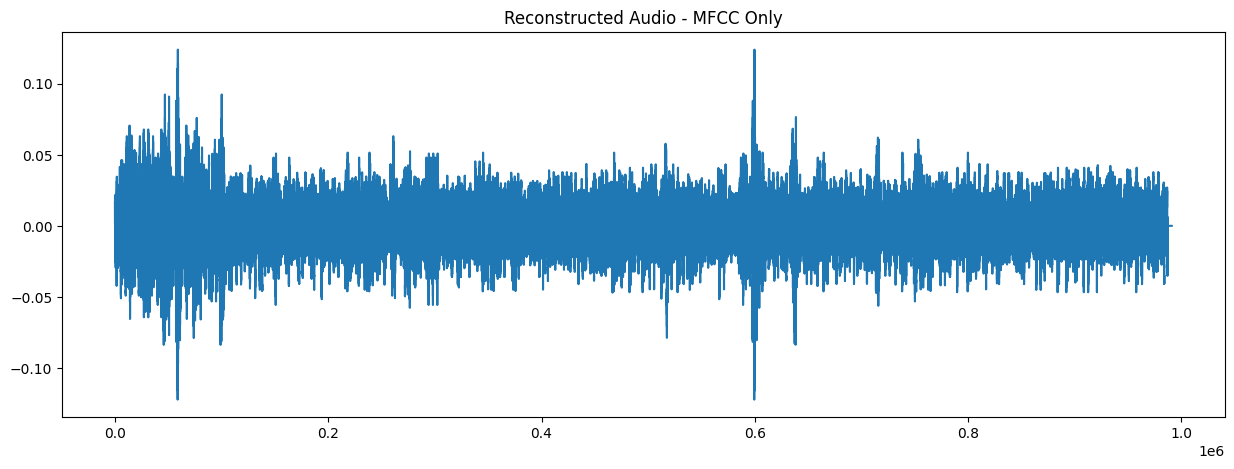

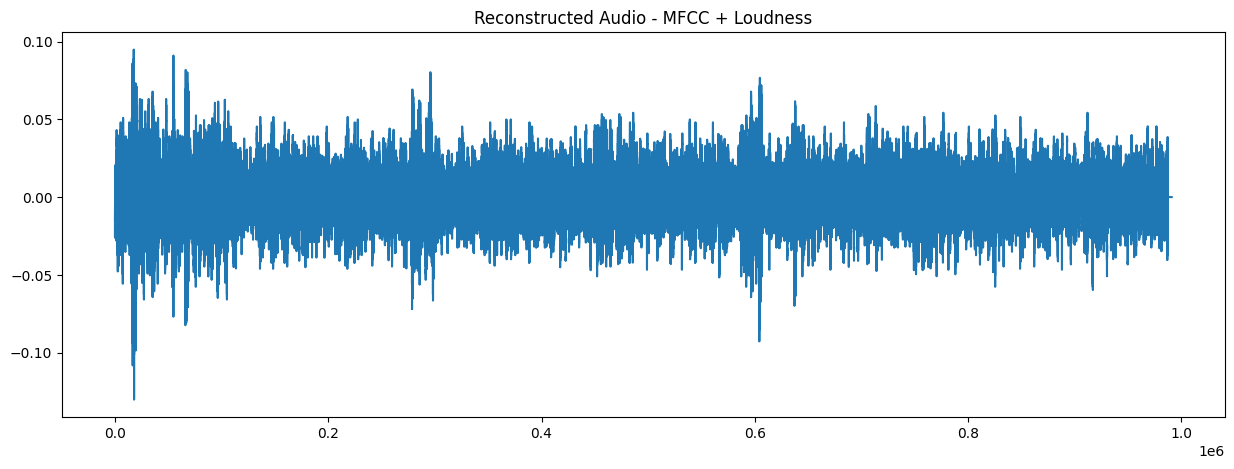

Reconstructed Audio (MFCC Only):


Reconstructed Audio (MFCC + Loudness):


In [5]:
# Write the reconstructed audios to disk for listening
output_filename_A = f"{df_target.iloc[0]['path']}_reconstructed_A.wav"
output_filename_B = f"{df_target.iloc[0]['path']}_reconstructed_B.wav"
estd.MonoWriter(filename=output_filename_A, format='wav', sampleRate=44100)(reconstructed_audio_A)
estd.MonoWriter(filename=output_filename_B, format='wav', sampleRate=44100)(reconstructed_audio_B)

print(f"Reconstructed audio (MFCC only) saved as: {output_filename_A}")
print(f"Reconstructed audio (MFCC + Loudness) saved as: {output_filename_B}")

# Plot waveforms for visual comparison
plt.figure(figsize=(15,5))
plt.plot(reconstructed_audio_A)
plt.title('Reconstructed Audio - MFCC Only')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(reconstructed_audio_B)
plt.title('Reconstructed Audio - MFCC + Loudness')
plt.show()

# Play audio players
print("Reconstructed Audio (MFCC Only):")
display(Audio(reconstructed_audio_A, rate=44100))
print("Reconstructed Audio (MFCC + Loudness):")
display(Audio(reconstructed_audio_B, rate=44100))


## Conclusion

We experimented with two different feature sets for selecting similar frames during audio mosaicing:
- **MFCC Only:** Using only MFCC coefficients for similarity.
- **MFCC + Loudness:** Combining loudness with MFCC coefficients.

By comparing the reconstructed audio outputs (via waveform plots and audio playback), you can evaluate how the choice of features influences the timbral similarity and overall reconstruction quality.

Feel free to further experiment by:
- Trying other feature combinations (e.g., including tonality information).
- Adjusting the number of neighbors or randomization in frame selection.
- Using different target files or frame sizes.

